# Block Group Correlation
This notebook contains code to compare data against the reference dataset, which is already contained within several of the preprocessed data files.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import beta
from scipy.stats import pearsonr, norm
from scipy.stats import t as student_t
from scipy.spatial import distance_matrix

import geopandas as gpd


# 2021
res = gpd.read_file('../preprocessed_data/durham_july_2021/durham_july_2021_block_group.shp')

# 2022
# res = gpd.read_file('../preprocessed_data/durham_july_2022/durham_july_2022_block_group.shp')

# 2023
# res = gpd.read_file('../preprocessed_data/durham_july_2023/durham_july_2023_block_group.shp')

To perform the analysis, we need to convert the distance to meters, then remove the block groups which do not have spatial causal model results (using the no_unobs column).

This will give us the dataset against which we can compare.

In [6]:
# Convert EPSG to 4326 for meters
res = res.set_crs(epsg=4269)
res = res.to_crs(epsg=3857)

before = len(res)
# Remove the n/a rows
mask = ~res['no_unobs'].isna()
res = res[mask]
after = len(res)

print("Before: ", before, " block groups.")
print("After: ", after, " block groups")

# Calculate center point of each census tract
res['center'] = res['geometry'].centroid
x, y = res['center'].x.values, res['center'].y.values
coords = np.vstack([x, y]).T
dist = distance_matrix(coords, coords)

Before:  235  block groups.
After:  196  block groups


[7.34384351e-01 2.17647217e-04]
[28, 286, 436, 576, 630, 830, 796, 984, 1056, 1026, 1154, 1186, 1288, 1240, 1372, 1326, 1344, 1216, 1438]
[0.53836527 0.00075037]
[28, 286, 436, 576, 630, 830, 796, 984, 1056, 1026, 1154, 1186, 1288, 1240, 1372, 1326, 1344, 1216, 1438]
[0.58158948 0.00069637]
[28, 286, 436, 576, 630, 830, 796, 984, 1056, 1026, 1154, 1186, 1288, 1240, 1372, 1326, 1344, 1216, 1438]
[28, 286, 436, 576, 630, 830, 796, 984, 1056, 1026, 1154, 1186, 1288, 1240, 1372, 1326, 1344, 1216, 1438]
[0.19468047 0.00066838]
[28, 286, 436, 576, 630, 830, 796, 984, 1056, 1026, 1154, 1186, 1288, 1240, 1372, 1326, 1344, 1216, 1438]
[0.12253023 0.00053471]


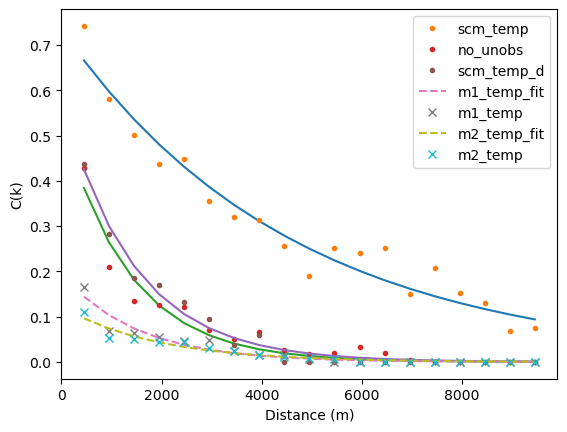

In [7]:
# Fit an exponential decay to the covariance

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

def calc_covariance(series, dist, bins):
    labels = []
    values = []
    counts = []
    mean_temp = np.nanmean(series)

    for b_lower, b_upper in zip(bins[:-1], bins[1:]):
        mask = (dist > b_lower) & (dist <= b_upper)

        diff = (series - mean_temp).reshape(-1, 1)
        diff = np.matmul(diff, diff.T)

        # Calculate the average of the differences
        avg_diff = np.sum(diff * mask) / mask.sum()

        labels.append((b_lower + b_upper) / 2)
        values.append(avg_diff)
        counts.append(mask.sum())

    return labels, values, counts

# Look at SCM_TEMP, NO_UNOBS, M1_TEMP, M2_TEMP

bins = np.arange(200, 10_000, 500)

cov_calcs = {}
for label in ['scm_temp', 'no_unobs', 'scm_temp_d']:#, 'm4_temp', 'eve_avg']:
    labels, values, c = calc_covariance(res[label].values, dist, bins)
    values = np.array([0 if v < 0 else v for v in values])
    gt0 = False
    for i, v in enumerate(values):
        if v == 0 :
            gt0 = True
        if gt0:
            values[i] = 0
    popt, pcov = curve_fit(exp_decay, labels, values, p0=[1, 1e-4])
    print(popt)
    cov_calcs[label] = [labels, values, exp_decay(np.array(labels), *popt)]
    print(c)
    plt.plot(labels, exp_decay(np.array(labels), *popt), '-')#, label=label + '_fit')
    plt.plot(labels, values, '.', label=label)


for label in ['m1_temp','m2_temp' ]:#, 'm4_temp', 'eve_avg']:
    labels, values, c = calc_covariance(res[label].values, dist, bins)
    print(c)
    # Replace all values < 0 with 
    values = np.array([0 if v < 0 else v for v in values])
    gt0 = False
    for i, v in enumerate(values):
        if v == 0 :
            gt0 = True
        if gt0:
            values[i] = 0
    popt, pcov = curve_fit(exp_decay, labels, values, p0=[1, 1e-4])
    print(popt)
    cov_calcs[label] = [labels, values, exp_decay(np.array(labels), *popt)]
    plt.plot(labels, exp_decay(np.array(labels), *popt), '--', label=label + '_fit')
    plt.plot(labels, values, 'x', label=label)

bin_counts = c
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("C(k)")
plt.show()

Now, we can look at the significance of individual correlation values.

In [8]:
from itertools import product

models = ['m1_temp', 'm2_temp']
truth = ['scm_temp', 'no_unobs', 'scm_temp_d']


# np.sum(cov_calcs['scm_temp_d'][2] * cov_calcs['m4_temp'][2] * np.array(bin_counts))

def r_sigma2(series1, series2, bin_counts):
    denom = len(res[series2])**2 * res[series1].std()**2 * res[series2].std()**2
    return np.sum(cov_calcs[series1][2] * cov_calcs[series2][2] * bin_counts) / denom


def compute_ess(s1, s2, bin_counts):
    rs2 = r_sigma2(s1, s2, bin_counts)
    M = 1 + 1/rs2
    return M, rs2


def calc_pearson_r(s1, s2):
    """Ensure all values are non-nan"""
    # mask = ((~res[s2].isna()) & (~res[s1].isna())).values
    return pearsonr(res[s1][mask].values, res[s2][mask].values)[0]

def calc_f_pdf(r, ess):
    num = (1 - r**2)**(ess/2 - 2)
    den = beta(0.5, ess/2 - 1)
    return num / den


def t_score(r, n ):
    
    return (n - 2)**0.5*r / (1 - r**2)**0.5


for m, t in product(models, truth):
    # Compute effective sample size
    ess, rs2 = compute_ess(m, t, bin_counts)

    # Calculate pearson correlation
    r = calc_pearson_r(m, t)
    # f_m = calc_f_pdf(r, ess)
    # Calculate the t-score then plug that into a T-table to calculate
    # the critical value.
    t_s = t_score(r, ess)

    # Calc critical value
    p = 1 - student_t.cdf(t_s, ess - 2)

    # CI95
    ci_95 = (1 - r**2)**0.5 / (ess - 2)**0.5

    print(f'{m} vs {t}: ESS={ess:.2f}, r={r:.3f}, t_s={t_s:.4f}, p={p:.4f}, CI95={r - 2*ci_95:.4f}, {r + 2*ci_95:.4f}')

m1_temp vs scm_temp: ESS=44.13, r=0.195, t_s=1.2894, p=0.1022, CI95=-0.1074, 0.4971
m1_temp vs no_unobs: ESS=56.30, r=0.351, t_s=2.7580, p=0.0040, CI95=0.0963, 0.6047
m1_temp vs scm_temp_d: ESS=59.29, r=0.182, t_s=1.3988, p=0.0836, CI95=-0.0781, 0.4416
m2_temp vs scm_temp: ESS=53.77, r=0.196, t_s=1.4405, p=0.0779, CI95=-0.0763, 0.4689
m2_temp vs no_unobs: ESS=75.69, r=0.458, t_s=4.4186, p=0.0000, CI95=0.2505, 0.6648
m2_temp vs scm_temp_d: ESS=79.21, r=0.351, t_s=3.2896, p=0.0008, CI95=0.1374, 0.5638


And using the code below, we can look at the significance of r-value differences.

In [9]:
def calc_z_score(r_x1x2, r_yx1, r_yx2, ess):
    z_ryx1 = 0.5 * np.log((1 + r_yx1) / (1 - r_yx1))
    z_ryx2 = 0.5 * np.log((1 + r_yx2) / (1 - r_yx2))
    cov = (r_x1x2*(1 - r_yx1**2 - r_yx2**2) - 0.5*(r_yx1*r_yx2)*(1 - r_yx1**2 - r_yx2**2 - r_x1x2**2)) / ((1 - r_yx1**2)*(1- r_yx2**2))

    z = (z_ryx1 - z_ryx2) / (2 - 2*cov)**0.5 * (ess - 2)**0.5

    return z

def calc_corr(s1, s2, s3):
    r1 = calc_pearson_r(s2, s3)
    r2 = calc_pearson_r(s1, s2)
    r3 = calc_pearson_r(s1, s3)

    ess_1, _ = compute_ess(s1, s2, bin_counts)
    ess_2, _ = compute_ess(s1, s3, bin_counts)
    print(ess_1, ess_2)
    ess = (ess_1 + ess_2) / 2
    # ess = 64
    z = calc_z_score(r1, r2, r3, ess)
    if z < 0:
        p = norm.cdf(z)
    else:
        p = 1 - norm.cdf(z)

    return z, p, ess


comparisons = [
    ['scm_temp', 'm1_temp', 'm2_temp'],
    ['no_unobs', 'm1_temp', 'm2_temp'],
    ['scm_temp_d', 'm1_temp', 'm2_temp'],
    ['m1_temp', 'scm_temp', 'no_unobs'],
    ['m2_temp', 'scm_temp', 'no_unobs'],
    ['m1_temp', 'scm_temp', 'scm_temp_d'],
    ['m2_temp', 'scm_temp', 'scm_temp_d'],
]

for row in comparisons:
    z, p, ess = calc_corr(*row)
    print(f'{row[1]} vs {row[2]} by {row[0]}: z={z:.4f}, p={p:.4f}, ESS={ess:.2f}')

44.12735825616749 53.76795180788797
m1_temp vs m2_temp by scm_temp: z=-0.0162, p=0.4935, ESS=48.95
56.29666155011982 75.68884433104763
m1_temp vs m2_temp by no_unobs: z=-1.5072, p=0.0659, ESS=65.99
59.287019228798066 79.21364642759595
m1_temp vs m2_temp by scm_temp_d: z=-2.3046, p=0.0106, ESS=69.25
44.12735825616749 56.29666155011982
scm_temp vs no_unobs by m1_temp: z=-1.5073, p=0.0659, ESS=50.21
53.76795180788797 75.68884433104763
scm_temp vs no_unobs by m2_temp: z=-2.9886, p=0.0014, ESS=64.73
44.12735825616749 59.287019228798066
scm_temp vs scm_temp_d by m1_temp: z=0.1212, p=0.4518, ESS=51.71
53.76795180788797 79.21364642759595
scm_temp vs scm_temp_d by m2_temp: z=-1.6753, p=0.0469, ESS=66.49
